In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Starting with Anomaly detection on weekly data

### Assemble stock data from yahoo finance

In [62]:
stocks = ['META', 'MSFT', 'XOM', '^GSPC'] # Meta, Microsoft, Exxon Mobil, S&P500 index

start_date = '2013-01-01' # META is missing data before May 2012, no NAs after
end_date = '2024-12-31'
data = yf.download(stocks, start=start_date, end=end_date)


[*********************100%***********************]  4 of 4 completed


In [63]:
# COlumn structure, and confirm no NAs
data.isna().sum()

Price   Ticker
Close   META      0
        MSFT      0
        XOM       0
        ^GSPC     0
High    META      0
        MSFT      0
        XOM       0
        ^GSPC     0
Low     META      0
        MSFT      0
        XOM       0
        ^GSPC     0
Open    META      0
        MSFT      0
        XOM       0
        ^GSPC     0
Volume  META      0
        MSFT      0
        XOM       0
        ^GSPC     0
dtype: int64

### Preprocessing of stock data
- For the given daily stock data, we will smooth it using moving average over 5 days, then make it weekly.
- Then we will log-transform the data and use the change for each week
- We will further standardize the log-transformed changes so that we can compare across the symbols as well
- Lastly we will visualize the normality and outliers using histograms and Q-Q plots to see if the log-transformed changes are appropriate to use for further analysis


In [64]:
# Apply rolling average over 5 days centered at each day
data_smooth = data.rolling(window=5, min_periods=1).mean()

# Resample to weekly and aggregate by mean
weekly_df = data_smooth.resample('W').mean().iloc[1:-1]

# Using log-transformed changes
log_changes = np.log(weekly_df / weekly_df.shift(1)).dropna()
# Standardize
log_changes = (log_changes - log_changes.mean())/log_changes.std()

Visualizing the distribution of log changes (first overall, then year-wise)

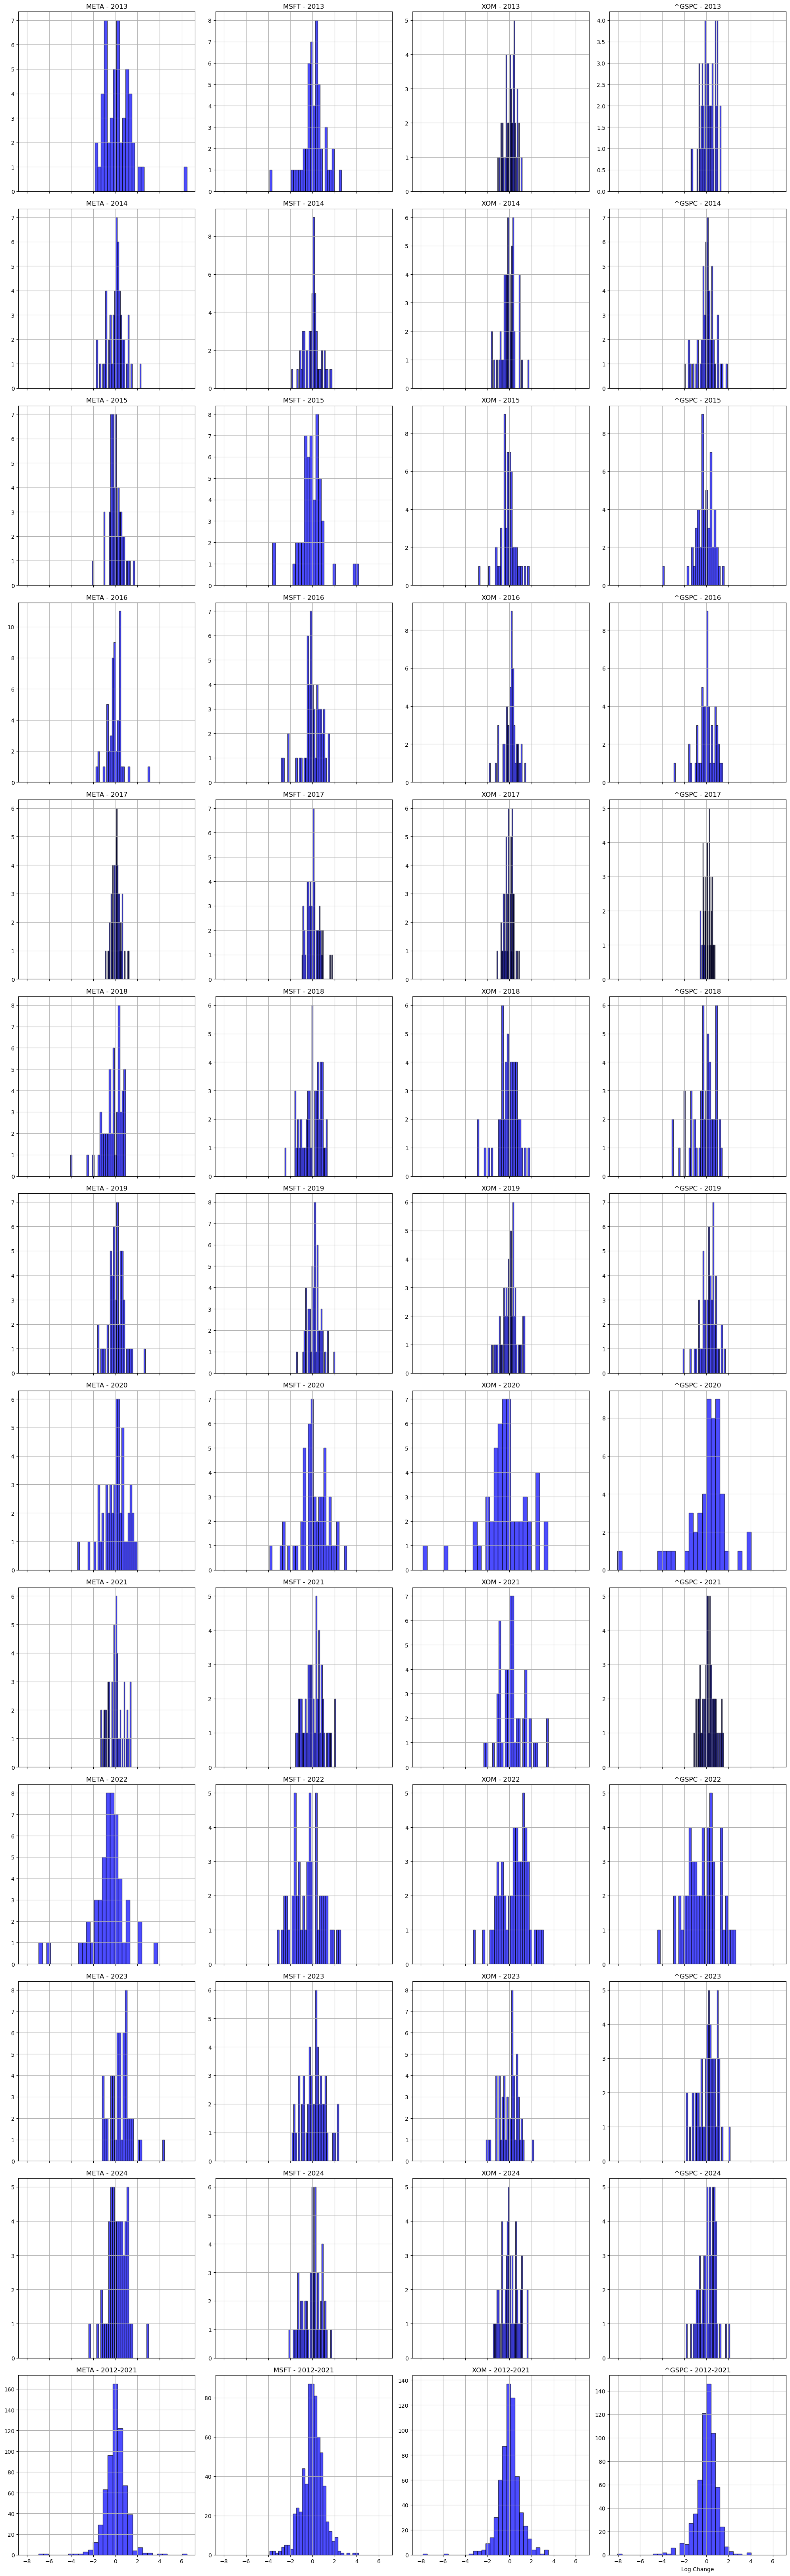

In [65]:
years = log_changes.index.year.unique()
Ny = len(years)
symbols = log_changes["Close"].columns

fig, axes = plt.subplots(Ny+1, len(symbols), figsize=(20, 5 * (Ny+1)), sharex=True)

for j, symbol in enumerate(symbols):
    for i, year in enumerate(years):
        ax = axes[i, j]
        yearly_data = log_changes["Close"].loc[str(year), symbol].dropna()

        ax.hist(yearly_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(f"{symbol} - {year}")
        ax.grid(True)
        # Plot for all years 2012-2021
    ax = axes[Ny, j]
    all_data = log_changes["Close"].loc[:, symbol].dropna()

    ax.hist(all_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f"{symbol} - 2012-2021")
    ax.grid(True)

plt.xlabel("Log Change")
plt.tight_layout()
plt.show()

Log-transformed changes look mostly unimodal (except for 2020, the year of pandemic shutdown)

Checking normality of log-transformed changes through q-q plots

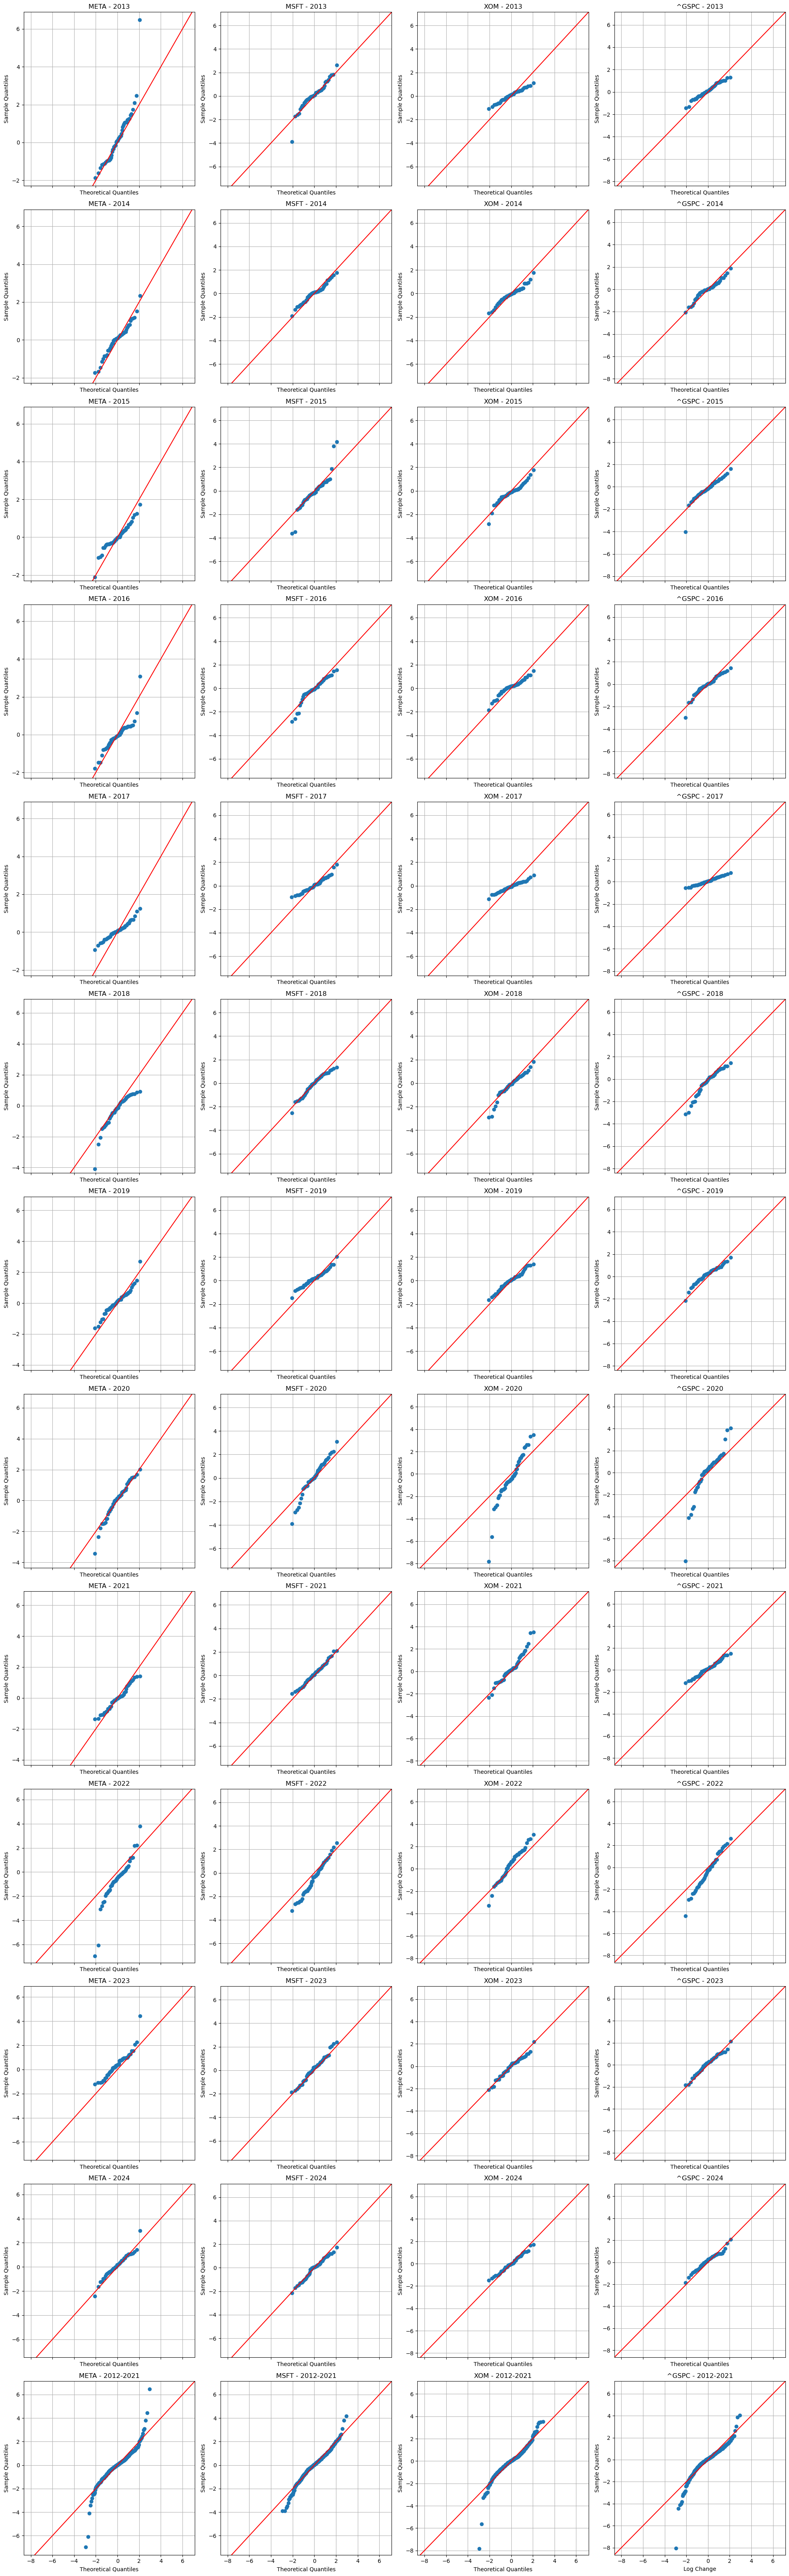

In [66]:
years = log_changes.index.year.unique()
Ny = len(years)
symbols = log_changes["Close"].columns

fig, axes = plt.subplots(Ny+1, len(symbols), figsize=(20, 5 * (Ny+1)), sharex=True)

for j, symbol in enumerate(symbols):
    for i, year in enumerate(years):
        ax = axes[i, j]
        yearly_data = log_changes["Close"].loc[str(year), symbol].dropna()

        sm.qqplot(yearly_data, line='45', ax = ax)
        ax.set_title(f"{symbol} - {year}")
        ax.grid(True)

    # Plot for all years 2012-2021
    ax = axes[Ny, j]
    all_data = log_changes["Close"].loc[:, symbol].dropna()

    sm.qqplot(all_data, line='45', ax = ax)
    ax.set_title(f"{symbol} - 2012-2021")
    ax.grid(True)


# Set labels
plt.xlabel("Log Change")
plt.tight_layout()
plt.show()

Q-Q plots of the log changes in closing price (averaged weekly) for each stock for each year as well as all years combined (in the last row).

Q-Q plots lie mostly on the diagonal, except for some years such as 2020 (the year of oandemic shutdown). Moreover, the plots deviate from the diagonal near the extreme ends.

Thus log-transformed changes are mostly normal, confirming that log transfomed changes is an appropriate preprocessing step.

The log-transformed changes are mostly normal, except for some years, and except near the tails. Thus there are outliers in the data. Interestingly we observe more negative change outliers than positive (in the last row, there are more deviations from the diagonal for negative quantiles than positive)

Thus, it will be interesting to discover such anomolous periods, and connect with the real-world events.

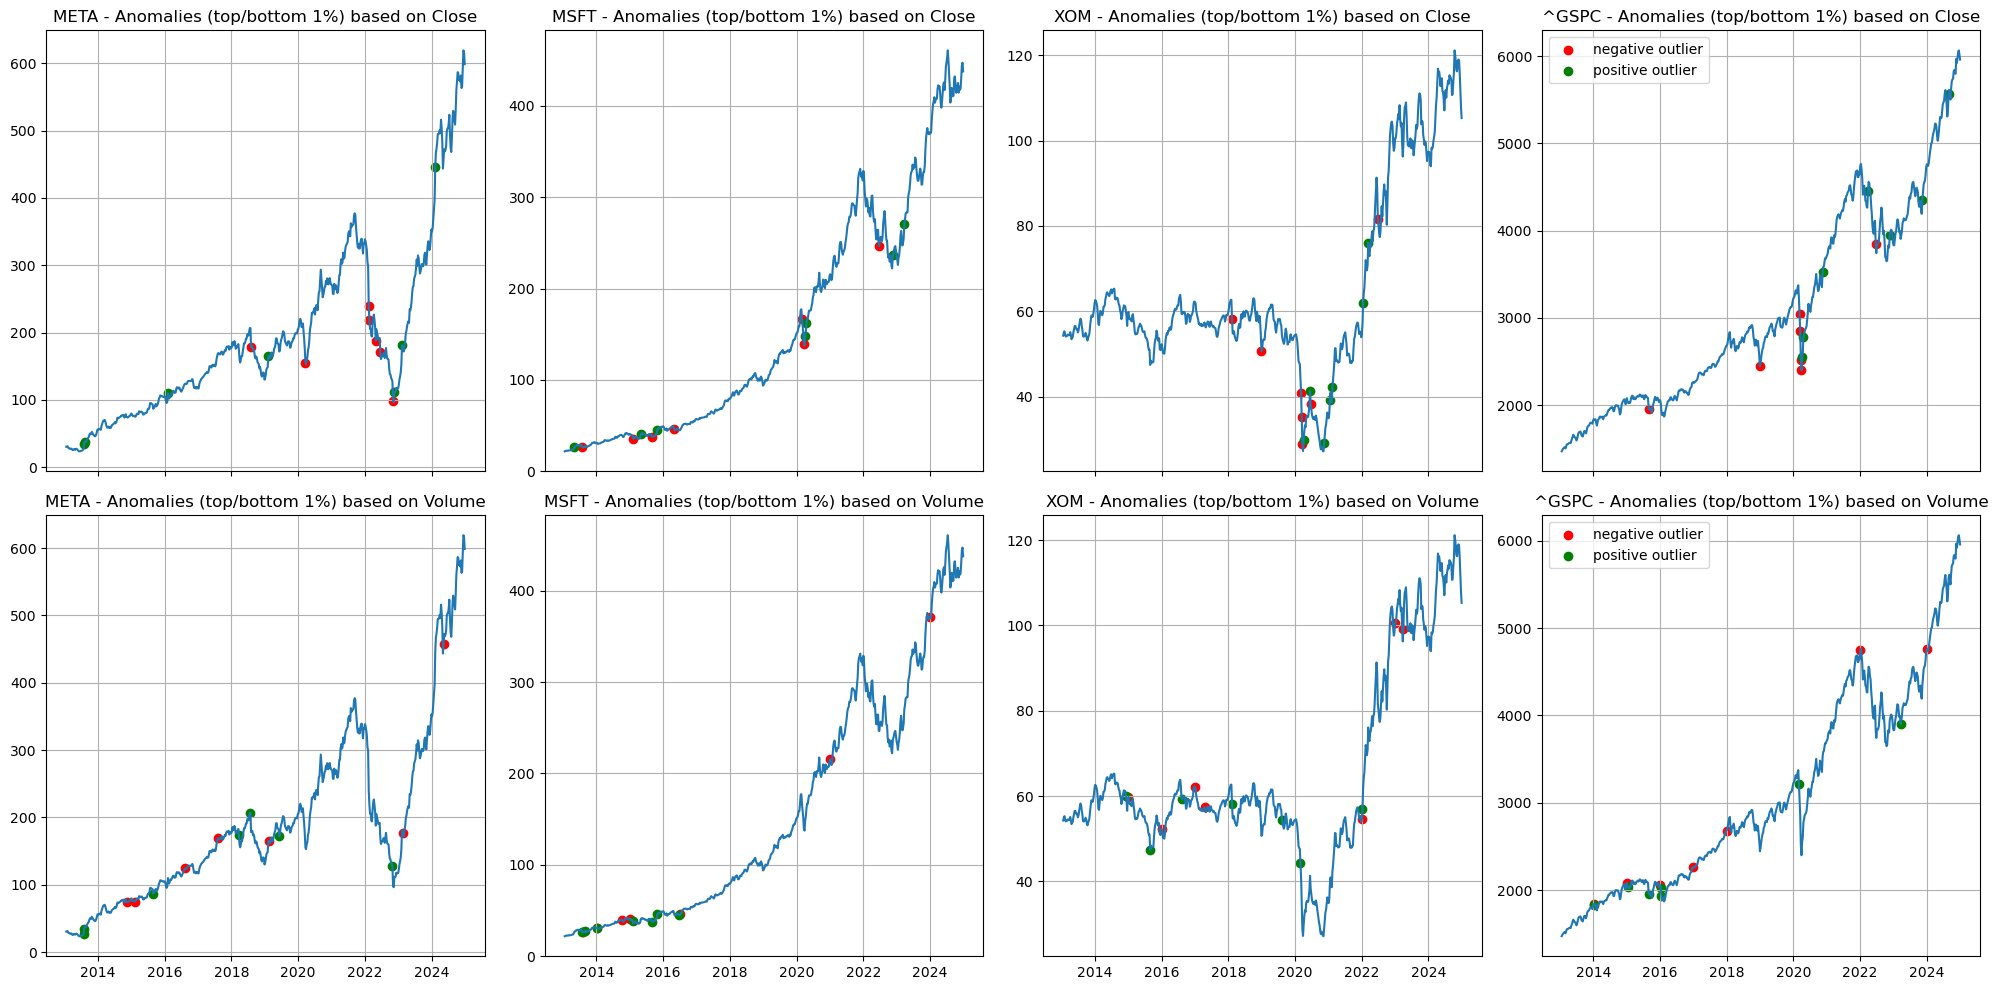

In [80]:
# Anomaly Detection using confidence intervals for each column

weekly_df = weekly_df.loc[log_changes.index]
anom_cols = ["Close","Volume"]
fig, axes = plt.subplots(len(anom_cols), len(symbols), figsize=(5*len(symbols), 5 * len(anom_cols)), sharex=True)

for i,col in enumerate(anom_cols):
    for j,sym in enumerate(symbols):
        ax = axes[i][j]
        low_anomalies = log_changes[col][sym] < np.percentile(log_changes[col][sym],1)
        high_anomalies = log_changes[col][sym] > np.percentile(log_changes[col][sym],99)
        ax.plot(log_changes.index,weekly_df["Close"][sym])
        ax.scatter(log_changes.index[low_anomalies],weekly_df["Close"][sym].loc[low_anomalies], color = "red",label = "negative outlier")
        ax.scatter(log_changes.index[high_anomalies],weekly_df["Close"][sym].loc[high_anomalies], color = "green",label = "positive outlier")
        ax.set_title(f"{sym} - Anomalies (outside 98%) based on {col}")
        ax.grid(True)

    ax.legend()
plt.tight_layout()
plt.show()

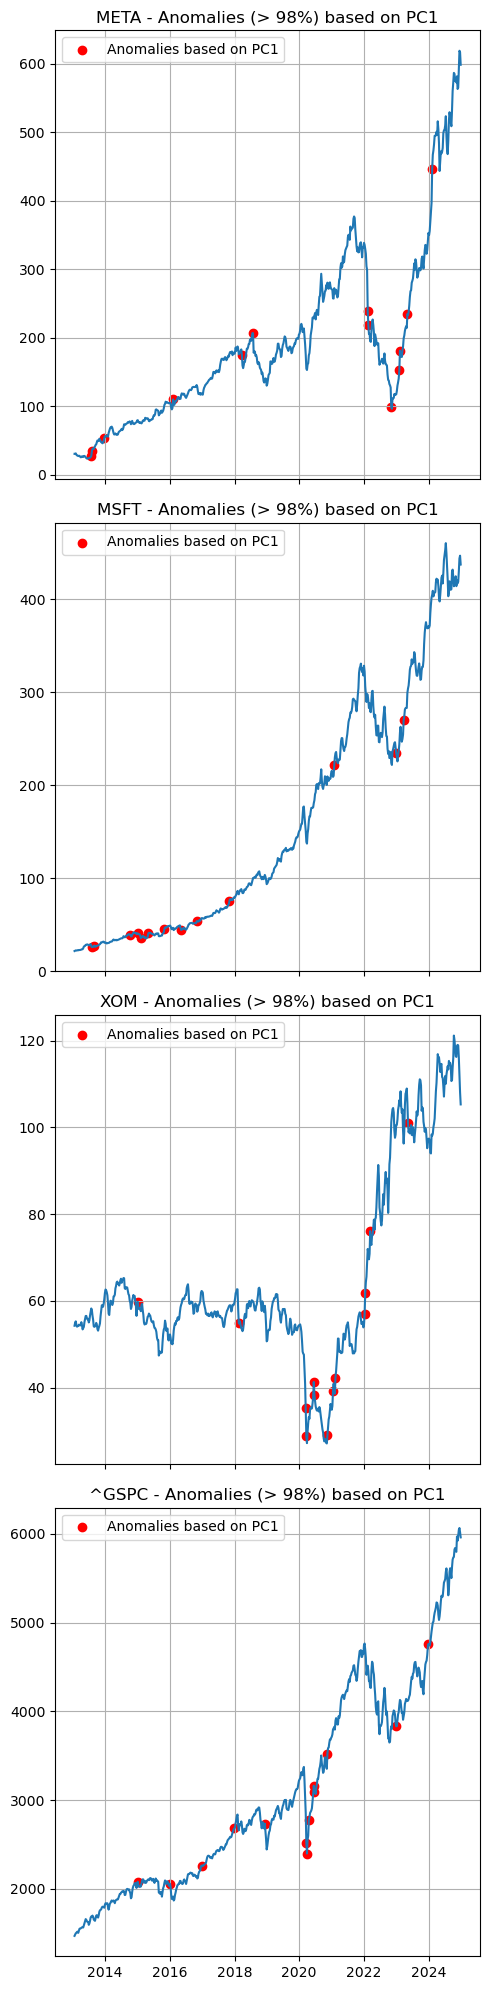

In [142]:
# Anomaly Detection using all columns together using PCA

# Anomaly Detection using confidence intervals for each column

weekly_df = weekly_df.loc[log_changes.index]
anom_cols = ["Close","Volume"]
fig, axes = plt.subplots(len(symbols), figsize=(5, 5*len(symbols)), sharex=True)

for i,sym in enumerate(symbols):
    ax = axes[i]
    
    # Get PCA 
    pca = PCA(n_components = 1)
    actual = log_changes[[(col,sym) for col in cols]]
    pc = pca.fit_transform(actual)

    # Reconstruction
    reconstructed = pca.inverse_transform(pc)
    reconstruction_error = np.sum((actual - reconstructed) ** 2, axis=1)

    # Identify anomalies (e.g., top 2% highest errors)
    threshold = np.percentile(reconstruction_error, 98)
    anomalies = reconstruction_error > threshold


    ax.plot(log_changes.index,weekly_df["Close"][sym])
    ax.scatter(log_changes.index[anomalies],weekly_df["Close"][sym].loc[anomalies], color = "red",label = "Anomalies based on PC1")
    ax.set_title(f"{sym} - Anomalies (> 98%) based on PC1")
    ax.grid(True)

    ax.legend()
plt.tight_layout()
plt.show()

pca = PCA()



In [121]:
sym = "MSFT"
pc = pca.fit_transform(log_changes[[("Close",sym),("Volume",sym),
# ("Open",sym),("High",sym),("Low",sym)
]])

In [122]:
pca.explained_variance_ratio_

array([0.55294454, 0.44705546])

In [125]:
cols = ["Close","Volume",
# "Open","High","Low"
]

np.array([[round(pd.DataFrame(log_changes[(col,sym)].values).corrwith(pd.DataFrame(pc[:,pc_i]),axis = 0),3) for pc_i in range(2)] for col in cols])

array([[[ 0.744],
        [ 0.669]],

       [[-0.744],
        [ 0.669]]])

PC1 is correlated with both Close price and Volume, so we sill use it for anomaly detection using percentil 95%

In [136]:
pca = PCA(n_components=1)  # Retain 95% variance
actual = log_changes[[("Close",sym),("Volume",sym)]]
pc = pca.fit_transform(actual)

# Reconstruction
reconstructed = pca.inverse_transform(pc)
reconstruction_error = np.sum((actual - reconstructed) ** 2, axis=1)

# Identify anomalies (e.g., top 5% highest errors)
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold



In [137]:
reconstruction_error

Date
2013-01-20    0.018948
2013-01-27    0.478806
2013-02-03    0.326035
2013-02-10    1.794258
2013-02-17    0.402886
                ...   
2024-12-01    0.017506
2024-12-08    0.129619
2024-12-15    0.607773
2024-12-22    0.325059
2024-12-29    0.222992
Freq: W-SUN, Length: 624, dtype: float64

In [89]:
log_changes[[("Close","MSFT"),("Volume","MSFT")]]

Price,Close,Volume
Ticker,MSFT,MSFT
Date,,
2013-01-20,-0.061669,0.256338
2013-01-27,0.464552,0.514025
2013-02-03,0.519589,0.287919
2013-02-10,-0.567676,-1.326661
2013-02-17,0.049783,-0.947431
...,...,...
2024-12-01,-0.034947,-0.152167
2024-12-08,0.950759,-0.441604
